In [1]:
import os
from PIL import Image
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt
import pandas as pd
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np

In [2]:
df = pd.read_csv('./data/train.csv')

In [484]:
img_path = os.path.join('./data/train', '4fd4d1f693c164e6.jpg')
img_path = os.path.join('./data/train', 'df5de038a077c34a.jpg')
img_path = os.path.join('./data/train', '02533d35fe935981.jpg')


image = Image.open(img_path).convert('RGB')

In [485]:
transform = A.Compose([
    # A.Resize(763, 763),
    A.ColorJitter(
    brightness=0, contrast=0, saturation=0, # 다른 효과는 끄고
    hue=0.5, # 색조(hue)만 최대치로 변경
    p=0.5 # 50% 확률로 적용
    ),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Rotate(limit=30, p=0.7),  # ±30도 자유 회전
    A.Rotate(
        limit=30, p=0.7,
        border_mode=0, value=(255,255,255)  # 흰색으로 채움
    ),
    A.RandomBrightnessContrast(p=0.5),  # 밝기/대비
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),  # 가우시안 노이즈
    A.MotionBlur(blur_limit=5, p=0.3),  # 모션 블러
    A.GridDistortion(p=0.3),  # 종이 찌그러짐처럼
    A.OpticalDistortion(distort_limit=0.2, shift_limit=0.2, p=0.3),  # 광학 왜곡
    A.ISONoise(color_shift=(0.01, 0.05), intensity=(0.1, 0.5), p=0.3),  # ISO 노이즈(카메라 촬영 느낌)
    A.ImageCompression(quality_lower=30, quality_upper=70, p=0.3),  # JPEG 압축 아티팩트
    # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    # ToTensorV2()
])

In [600]:
flip_transform = A.Rotate(limit=360, p=0.7)
transform = A.Compose([
    A.ISONoise(color_shift=(0.01, 0.07), intensity=(0.3, 0.8), p=0.7),
    A.ColorJitter(
        brightness=0, contrast=0, saturation=0, # 다른 효과는 끄고
        hue=0.5, # 색조(hue)만 최대치로 변경
        p=0.7# 50% 확률로 적용
        ),
    A.GaussianBlur(blur_limit=(3,7), p=0.5),
    A.Rotate(
        limit=360, p=0.7,
        border_mode=0, value=(255,255,255)  # 흰색으로 채움
    ),
])



In [601]:
from augraphy import AugraphyPipeline, Letterpress, VoronoiTessellation, Hollow
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# augmentation sequence
my_sequence = [
    VoronoiTessellation(
        num_cells_range=(2000,2000),
        mult_range=(50,80),
        seed=42,
        noise_type="random",
        background_value=(100,150),
        numba_jit=1,
        p=0.7
),
]
pipeline  = AugraphyPipeline(my_sequence)

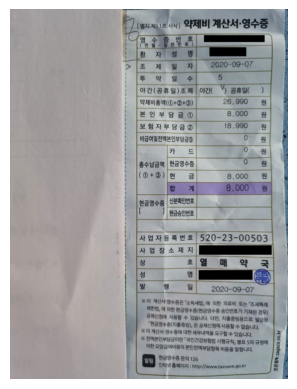

In [602]:
plt.imshow(image)
plt.axis("off")
plt.show()

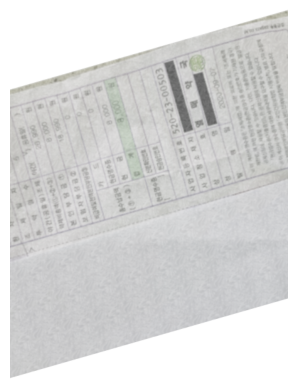

In [616]:
augmented_image = pipeline.augment(np.array(image))['output']
plt.imshow(transform(image=augmented_image)['image'])
plt.axis("off")
plt.show()

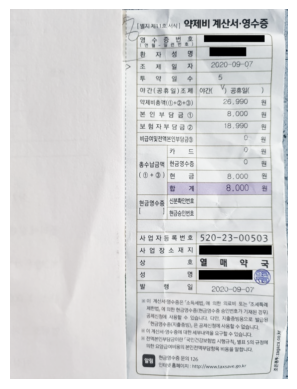

In [545]:
augmented_image = pipeline.augment(np.array(image))['output']
plt.imshow(augmented_image)
plt.axis("off")
plt.show()

In [219]:
plt.imshow(np.array(transform(image=np.array(image))['image']))
plt.axis("off")
plt.show()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

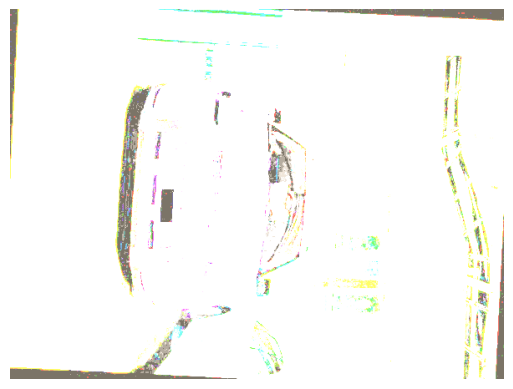

In [331]:
images = transform(image=np.array(image))['image']
mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])
img_numpy = images.permute(1, 2, 0).cpu().numpy()  # (HWC)
img_numpy = img_numpy * std + mean
img_numpy = np.clip(img_numpy, 0, 1)

plt.imshow(img_numpy)
plt.axis("off")
plt.show()

In [76]:
max_w=0
max_h=0
for i in [files for root,dir,files in os.walk('./data/train')][0]:
    img = Image.open(os.path.join('./data/train', i))
    w,h = img.size
    if w>max_w:
        max_w=w
    if h>max_h:
        max_h=h

for i in [files for root,dir,files in os.walk('./data/test')][0]:
    img = Image.open(os.path.join('./data/test', i))
    w,h = img.size
    if w>max_w:
        max_w=w
    if h>max_h:
        max_h=h

print('이미지 최대 사이즈: ',max_w,max_h)

이미지 최대 사이즈:  763 763


In [77]:
df['target'].value_counts()

target
16    100
10    100
4     100
5     100
15    100
9     100
7     100
2     100
11    100
3     100
0     100
8     100
12    100
6     100
13     74
14     50
1      46
Name: count, dtype: int64

In [325]:
  # 전체 데이터 로드
full_data = pd.read_csv('./data/train.csv')
traget_count = full_data['target'].value_counts().reset_index(name='count')
traget_count['augmented_count'] = traget_count['count'].apply(lambda x : 150 - x)






    target  count
0       16    100
1       10    100
2        4    100
3        5    100
4       15    100
5        9    100
6        7    100
7        2    100
8       11    100
9        3    100
10       0    100
11       8    100
12      12    100
13       6    100
14      13     74
15      14     50
16       1     46


0      50
1      50
2      50
3      50
4      50
5      50
6      50
7      50
8      50
9      50
10     50
11     50
12     50
13     50
14     76
15    100
16    104
Name: count, dtype: int64

In [413]:
pd.read_csv('temp_train.csv')['target'].value_counts().reset_index(name='count')

,target,count
0,16,75
1,3,75
2,4,75
3,1,75
4,15,75
5,2,75
6,11,75
7,10,75
8,14,75
9,12,75
